In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torch torchvision timm matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [10]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

data_dir = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_converted'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(root=data_dir, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [12]:
import timm
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_nasnet = timm.create_model('nasnetalarge', pretrained=True)
model_nasnet.num_classes = len(dataset.classes)
model_nasnet.last_linear = nn.Linear(model_nasnet.last_linear.in_features, model_nasnet.num_classes)
model_nasnet = model_nasnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_nasnet.parameters(), lr=3e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [13]:
epochs = 25
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model_nasnet.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_nasnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    scheduler.step()

    model_nasnet.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_nasnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

Epoch 1/25, Train Loss: 2.7349, Train Acc: 34.76%, Val Loss: 2.1914, Val Acc: 65.40%
Epoch 2/25, Train Loss: 1.4950, Train Acc: 82.59%, Val Loss: 0.9351, Val Acc: 85.71%
Epoch 3/25, Train Loss: 0.5877, Train Acc: 94.01%, Val Loss: 0.3346, Val Acc: 96.51%
Epoch 4/25, Train Loss: 0.1547, Train Acc: 98.64%, Val Loss: 0.1549, Val Acc: 97.46%
Epoch 5/25, Train Loss: 0.0575, Train Acc: 99.52%, Val Loss: 0.1180, Val Acc: 97.78%
Epoch 6/25, Train Loss: 0.0375, Train Acc: 99.73%, Val Loss: 0.1045, Val Acc: 97.78%
Epoch 7/25, Train Loss: 0.0228, Train Acc: 99.93%, Val Loss: 0.0954, Val Acc: 98.10%
Epoch 8/25, Train Loss: 0.0143, Train Acc: 99.93%, Val Loss: 0.1166, Val Acc: 96.51%
Epoch 9/25, Train Loss: 0.0155, Train Acc: 99.86%, Val Loss: 0.0860, Val Acc: 98.10%
Epoch 10/25, Train Loss: 0.0179, Train Acc: 100.00%, Val Loss: 0.0843, Val Acc: 98.73%
Epoch 11/25, Train Loss: 0.0124, Train Acc: 99.80%, Val Loss: 0.0883, Val Acc: 97.78%
Epoch 12/25, Train Loss: 0.0139, Train Acc: 99.93%, Val Loss: 

Test Accuracy: 98.10%


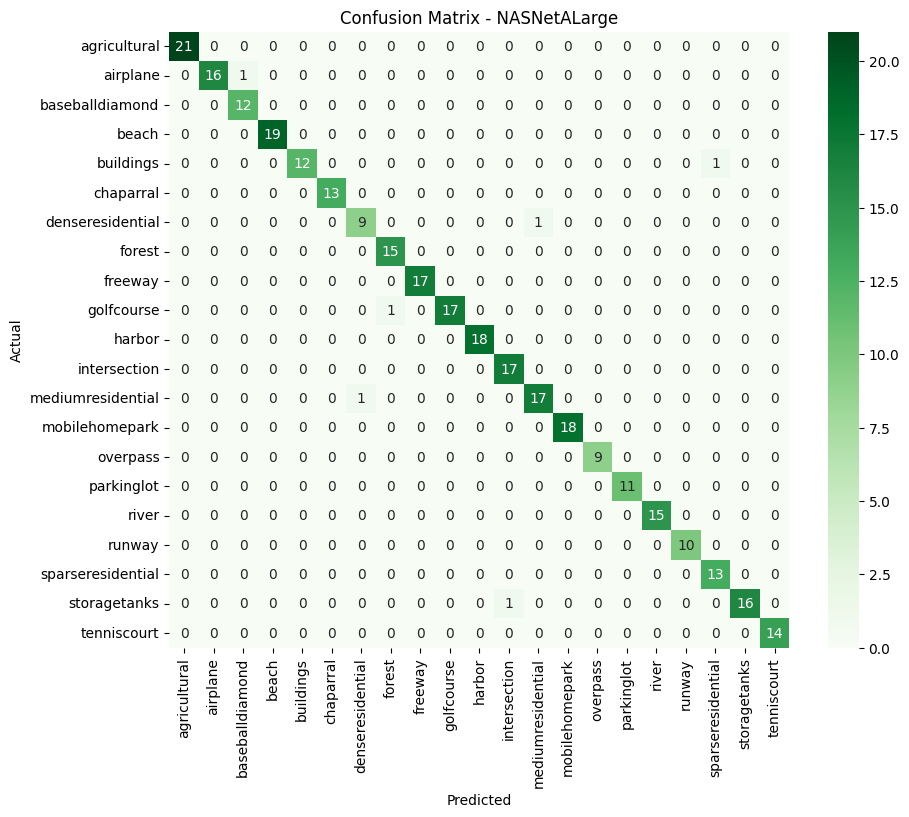

Classification Report:
                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        21
         airplane       1.00      0.94      0.97        17
  baseballdiamond       0.92      1.00      0.96        12
            beach       1.00      1.00      1.00        19
        buildings       1.00      0.92      0.96        13
        chaparral       1.00      1.00      1.00        13
 denseresidential       0.90      0.90      0.90        10
           forest       0.94      1.00      0.97        15
          freeway       1.00      1.00      1.00        17
       golfcourse       1.00      0.94      0.97        18
           harbor       1.00      1.00      1.00        18
     intersection       0.94      1.00      0.97        17
mediumresidential       0.94      0.94      0.94        18
   mobilehomepark       1.00      1.00      1.00        18
         overpass       1.00      1.00      1.00         9
       parkinglot       1.00    

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model_nasnet.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_nasnet(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - NASNetALarge')
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

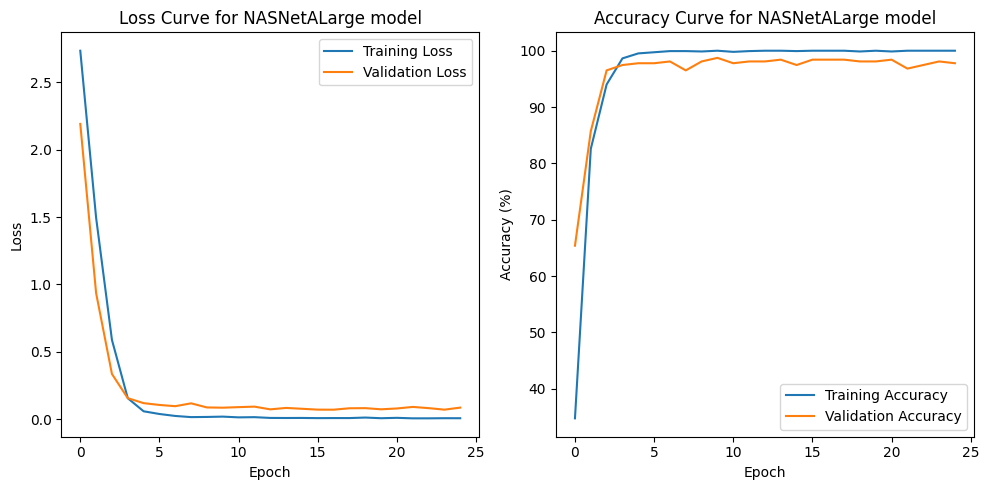

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve for NASNetALarge model')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve for NASNetALarge model')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Validation Accuracy: 97.78%
Test Accuracy: 98.10%
